In [1]:
import tensorflow as tf 

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Tensorflow: ", tf.__version__)


Python:  3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
pandas:  2.0.0
numpy:  1.22.2
seaborn:  0.12.2
matplotlib:  3.7.1
sklearn:  1.2.2
Tensorflow:  2.7.0


In [2]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()

In [3]:
tensorlogs = ["art_daily_no_noise", #0
              "art_daily_nojump", #1
              "art_daily_jumpsdown",#2 
              "art_daily_perfect_square_wave", #3 
              "art_increase_spike_density",  #4
              "art_load_balancer_spikes",  #5
              "ambient_temperature_system_failure", #6 
              "nyc_taxi",  #7
              "ec2_cpu_utilization", #8
              "rds_cpu_utilization"] #9 

dataFilePaths = ['data/art_daily_no_noise.csv',
                 'data/art_daily_nojump.csv',
                 'data/art_daily_jumpsdown.csv',
                 'data/art_daily_perfect_square_wave.csv',
                 'data/art_increase_spike_density.csv',
                 'data/art_load_balancer_spikes.csv',
                 'data/ambient_temperature_system_failure.csv',
                 'data/nyc_taxi.csv',
                 'data/ec2_cpu_utilization.csv',
                 'data/rds_cpu_utilization.csv']


In [35]:
i = 7

tensorlog = tensorlogs[i]
dataFilePath = dataFilePaths[i]
print("tensorlog: ", tensorlog)
print("dataFilePath: ", dataFilePath)


tensorlog:  nyc_taxi
dataFilePath:  data/nyc_taxi.csv


In [36]:
df = pd.read_csv(filepath_or_buffer=dataFilePath, header=0, sep=',')
print('Shape:' , df.shape[0])
print('Head:')
print(df.head(5))


Shape: 10320
Head:
             timestamp  value
0  2014-07-01 00:00:00  10844
1  2014-07-01 00:30:00   8127
2  2014-07-01 01:00:00   6210
3  2014-07-01 01:30:00   4656
4  2014-07-01 02:00:00   3820


             timestamp  value            Datetime
0  2014-07-01 00:00:00  10844 2014-07-01 00:00:00
1  2014-07-01 00:30:00   8127 2014-07-01 00:30:00
2  2014-07-01 01:00:00   6210 2014-07-01 01:00:00


Text(0.5, 1.0, 'Time Series of value by date time')

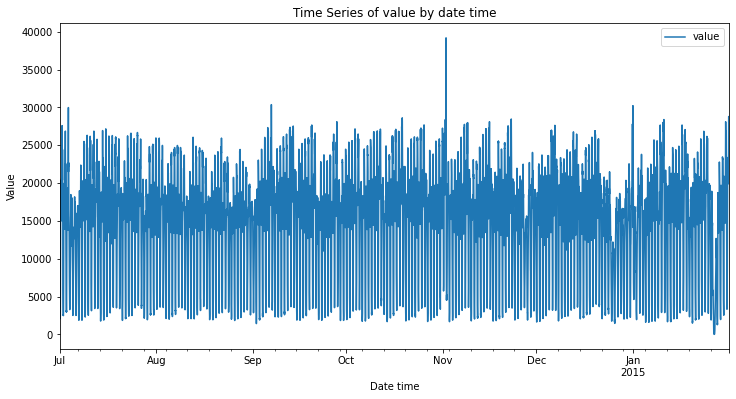

In [37]:
df['Datetime'] = pd.to_datetime(df['timestamp'])
print(df.head(3))
df.shape
df.plot(x='Datetime', y='value', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
df['scaled_value'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df['value'])),columns=['value']) - 0.5
print('Shape:' , df.shape[0])
df.head(5)

Shape: 10320


,timestamp,value,Datetime,scaled_value
0,2014-07-01 00:00:00,10844,2014-07-01 00:00:00,-0.223494
1,2014-07-01 00:30:00,8127,2014-07-01 00:30:00,-0.292825
2,2014-07-01 01:00:00,6210,2014-07-01 01:00:00,-0.341741
3,2014-07-01 01:30:00,4656,2014-07-01 01:30:00,-0.381395
4,2014-07-01 02:00:00,3820,2014-07-01 02:00:00,-0.402728


In [39]:
time_steps = 16

sequence = np.array(df['scaled_value'])
print(sequence)

# Create rolling window sequences as determined by time_steps
x_sequences = []
y_sequences = []

# Number of windows to iterate through
n_iter = len(sequence) - time_steps + 1
for f in range(n_iter):
    window = sequence[f:f+time_steps]
    x_sequences.append(window[:-1])
    y_sequences.append(window[-1:])
x_sequences = np.array(x_sequences)
y_sequences = np.array(y_sequences)
print(x_sequences.shape, y_sequences.shape)

[-0.22349384 -0.29282452 -0.3417413  ...  0.19664957  0.1783281
  0.17059634]
(10305, 15) (10305, 1)


In [40]:
sequences_x = x_sequences.reshape(len(x_sequences), time_steps-1, 1)
print("sequences_x: ", sequences_x.shape)
sequences_y = y_sequences.reshape(len(y_sequences), 1)
print("sequences_y: ", sequences_y.shape)

# Training on first half of data only, predicting on whole thing
stop_point = int(0.5 * len(df))
training_x = sequences_x[:stop_point]
print("training_x: ", training_x.shape)
training_y = sequences_y[:stop_point]
print("training_y: ", training_y.shape)

sequences_x:  (10305, 15, 1)
sequences_y:  (10305, 1)
training_x:  (5160, 15, 1)
training_y:  (5160, 1)


In [41]:

def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def call(self, x):
    length = tf.shape(x)[1]

    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [42]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,)
      
        # use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [43]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [44]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.


In [45]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [46]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)
    self.flat = tf.keras.layers.Flatten()
    self.final_layer = tf.keras.layers.Dense(1)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)
    x = self.flat(x)
    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [66]:
# Setting seed
tf.random.set_seed(2)
np.random.seed(2)

In [67]:
num_layers = 6
d_model = 64
dff = 128
num_heads = 4
dropout_rate = 0.1

transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=1,
    target_vocab_size=1,
    dropout_rate=dropout_rate)


In [68]:
output = transformer((training_x, training_x))

transformer.summary()


Model: "transformer_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_3 (Encoder)         multiple                  499200    
                                                                 
 decoder_3 (Decoder)         multiple                  898176    
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_99 (Dense)            multiple                  961       
                                                                 
Total params: 1,398,337
Trainable params: 1,398,337
Non-trainable params: 0
_________________________________________________________________


In [69]:
transformer.compile(
    loss='mean_absolute_error',
    optimizer='adam',
    metrics=['mean_absolute_error'])


In [70]:
history = transformer.fit((training_x, training_x), training_y,
                epochs=8,)


Epoch 1/8
162/162 [==============================] - 38s 166ms/step - loss: 0.2355 - mean_absolute_error: 0.2355
Epoch 2/8
162/162 [==============================] - 27s 166ms/step - loss: 0.0885 - mean_absolute_error: 0.0885
Epoch 3/8
162/162 [==============================] - 26s 164ms/step - loss: 0.0679 - mean_absolute_error: 0.0679
Epoch 4/8
162/162 [==============================] - 27s 164ms/step - loss: 0.0557 - mean_absolute_error: 0.0557
Epoch 5/8
162/162 [==============================] - 26s 162ms/step - loss: 0.0495 - mean_absolute_error: 0.0495
Epoch 6/8
162/162 [==============================] - 26s 162ms/step - loss: 0.0552 - mean_absolute_error: 0.0552
Epoch 7/8
162/162 [==============================] - 27s 164ms/step - loss: 0.0434 - mean_absolute_error: 0.0434
Epoch 8/8
162/162 [==============================] - 27s 164ms/step - loss: 0.0455 - mean_absolute_error: 0.0455


In [71]:
import math
from sklearn.metrics import mean_squared_error
                                  
testing_dataset = sequences_x
print("testing_dataset: ", testing_dataset.shape)

print("sequences_y: ", sequences_y.shape)

testing_pred = transformer.predict(x=(testing_dataset, testing_dataset))
print("testing_pred: ", testing_pred.shape)

errorsDF = sequences_y - testing_pred
print(errorsDF.shape)
rmse = math.sqrt(mean_squared_error(sequences_y, testing_pred))
print('Test RMSE: %.3f' % rmse)


testing_dataset:  (10305, 15, 1)
sequences_y:  (10305, 1)
testing_pred:  (10305, 1)
(10305, 1)
Test RMSE: 0.039


In [72]:
#based on cutoff after sorting errors
# Calculate threshold using training error
dist = np.linalg.norm(sequences_y[:len(training_y)] - testing_pred[:len(training_y)], axis=-1)

scores =dist.copy()
print(scores.shape)
scores.sort()
cutoff = int(0.999 * len(scores))
print(cutoff)
threshold= scores[cutoff]

# Calculate total error over full sequence
dist = np.linalg.norm(sequences_y[:] - testing_pred, axis=-1)

print(threshold)


(5160,)
5154
0.13164996056429368


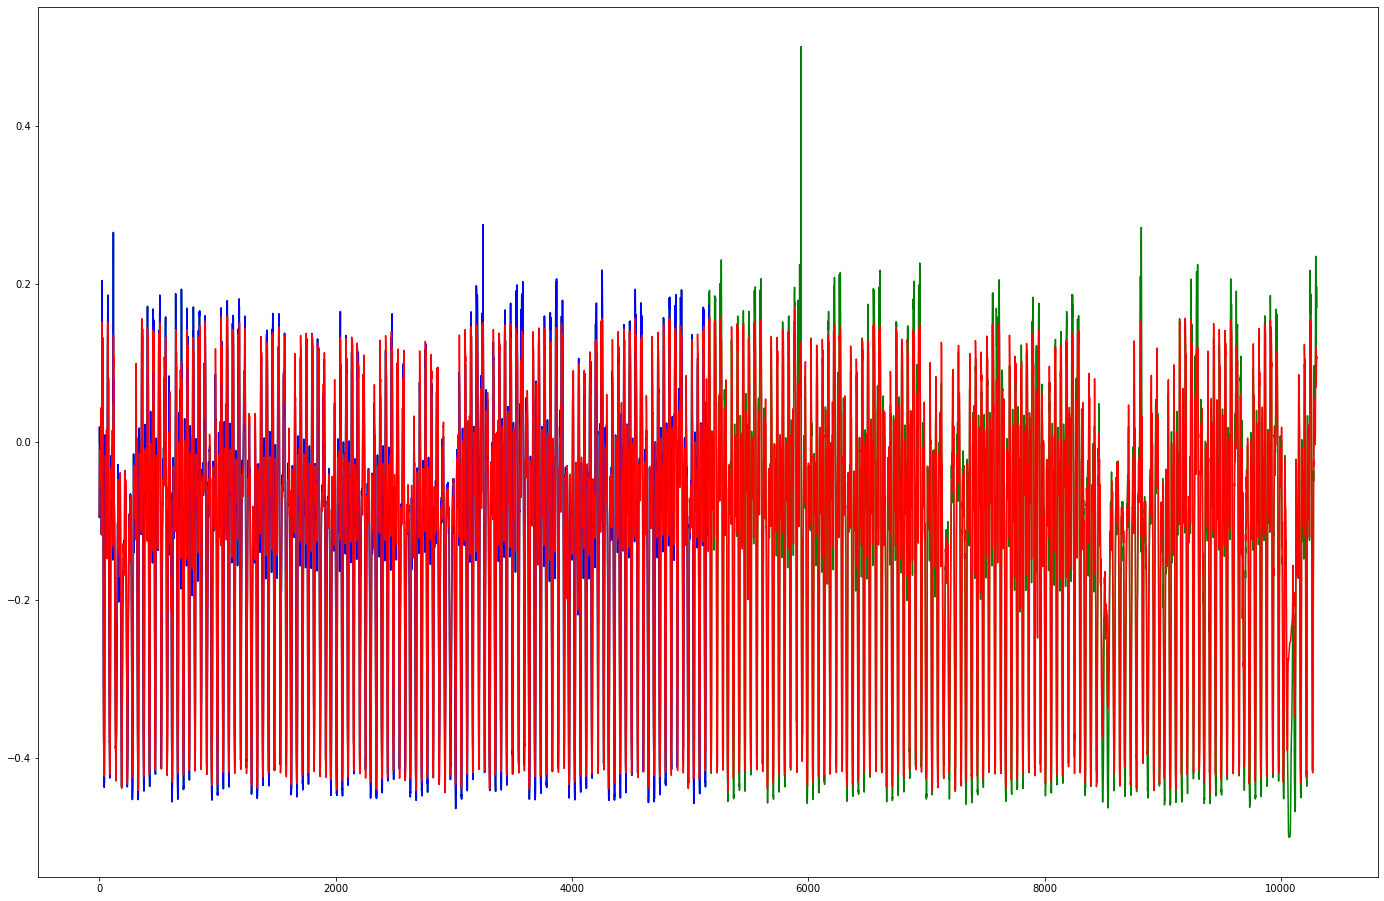

In [73]:
plt.figure(figsize=(24,16))
plt.plot(sequences_y, color='green')
plt.plot(training_y, color='blue')
plt.plot(testing_pred, color='red')


In [74]:
#label the records anomalies or not based on threshold
z = zip(dist >= threshold, dist)

y_label=[]
error = []
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(dist)


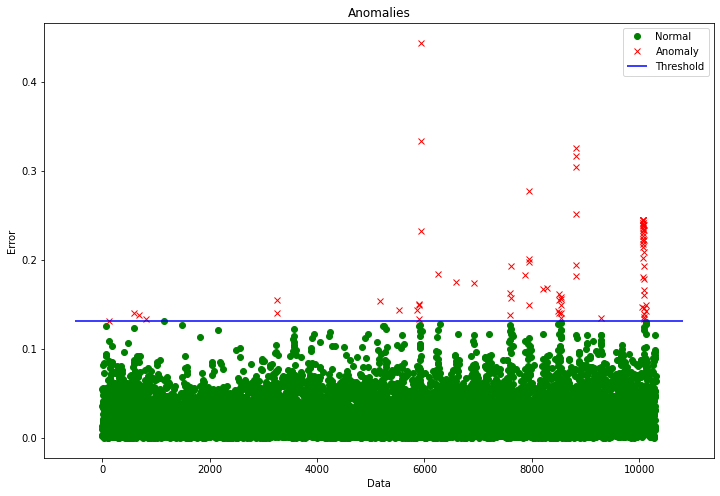

In [75]:
viz = Visualization()
viz.draw_anomaly(y_label, error, threshold)


In [76]:
adf = pd.DataFrame({'Datetime': df['Datetime'], 'observation': df['value'],
                    'error': [0 for f in range((time_steps-1))] + error, 'anomaly': [0 for f in range((time_steps-1))]+ y_label})
adf.head(5)


,Datetime,observation,error,anomaly
0,2014-07-01 00:00:00,10844,0.0,0
1,2014-07-01 00:30:00,8127,0.0,0
2,2014-07-01 01:00:00,6210,0.0,0
3,2014-07-01 01:30:00,4656,0.0,0
4,2014-07-01 02:00:00,3820,0.0,0


Text(0.5, 1.0, 'Time Series of value by date time')

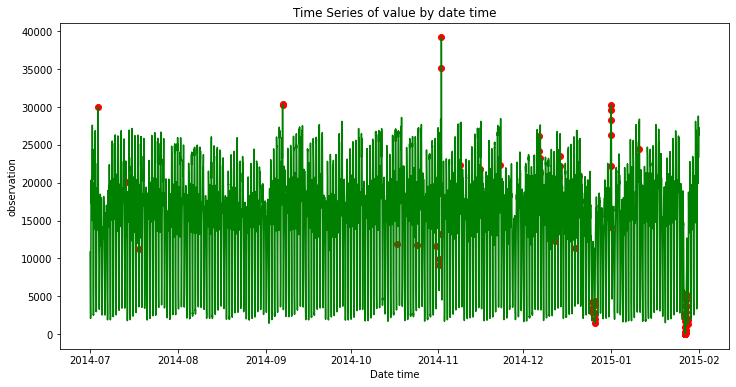

In [77]:
figure, axes = plt.subplots(figsize=(12, 6))
axes.plot(adf['Datetime'], adf['observation'], color='g')
anomaliesDF = adf.query('anomaly == 1')
axes.scatter(anomaliesDF['Datetime'].values, anomaliesDF['observation'], color='r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')
